<a href="https://colab.research.google.com/github/bsp73/cayuga-capital/blob/main/GRU_S%26P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook

In [ ]:
!pip install yfinance --quiet
!pip install torch
!pip install sklearn
!pip install numpy, pandas --quiet
!pip install ta

     |████████████████████████████████| 62 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=a1b6486ac4d9bc13e29323c719213b928052de4d6549e3ff2a3d70ef2cf7515b
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
ERROR: Invalid requirement: 'numpy,'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=90e9a1d59808af2e113af2cb0f91794637f67a3fd6eb588491a8385d405eba8f
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
from ta.volatility import bollinger_hband_indicator, bollinger_lband_indicator, bollinger_wband, average_true_range
from ta.momentum import rsi
from ta.trend import macd_diff

In [ ]:
sp = yf.Ticker("SPY")
data = sp.history(start="2020-03-30", end="2022-04-24")
data = data[['Close','Open','High','Low','Volume']]

In [ ]:
close = data['Close']

# EMAs
data['ema20'] = close.ewm(span = 20, adjust = False).mean()
data['ema50'] = close.ewm(span = 50, adjust = False).mean()
data['ema200'] = close.ewm(span = 200, adjust = False).mean()

# 1st and 2nd differences
data['First Diff'] = close.diff()
data['Second Diff'] = data['First Diff'].diff()

# Bollinger Band indicators and widths
data['BBand H 1hot'] = bollinger_hband_indicator(close)
data['BBand L 1hot'] = bollinger_lband_indicator(close)
data['BBand Channel Width'] = bollinger_wband(close) # equal to 4 times the standard deviation, a measure of volatility

# other indicators
data['RSI'] = rsi(close)
data['MACD Diff'] = macd_diff(close)
data['Day of Week'] = [x.dayofweek for x in data.index.tolist()]

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.apply(pd.Series.first_valid_index)

Close                   0
Open                    0
High                    0
Low                     0
Volume                  0
ema20                   0
ema50                   0
ema200                  0
First Diff              1
Second Diff             2
BBand H 1hot            0
BBand L 1hot            0
BBand Channel Width    19
RSI                    13
MACD Diff              33
Day of Week             0
dtype: int64

In [ ]:
data = data.iloc[33:]

In [ ]:
data.dtypes

Close                  float64
Open                   float64
High                   float64
Low                    float64
Volume                   int64
ema20                  float64
ema50                  float64
ema200                 float64
First Diff             float64
Second Diff            float64
BBand H 1hot           float64
BBand L 1hot           float64
BBand Channel Width    float64
RSI                    float64
MACD Diff              float64
Day of Week              int64
dtype: object

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)
close = scaler.fit_transform(np.array(close).reshape(-1,1))

In [ ]:
def split_data_og(stock, lookback):
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(stock) - lookback): 
        data.append(stock[index : index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return x_train, y_train, x_test, y_test
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data_og(data, lookback)

In [ ]:
def split_data(stock, lookback):
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(stock) - lookback): 
        data.append(stock[index : index + lookback].flatten(order='F').reshape(-1,1))
    
    data = np.array(data);
    print(data.shape)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    cols = stock.shape[1]*lookback
    ind_of_current = list(range(-1, cols, lookback))[1:]
    ind_of_past = list(set(range(0,cols)) - set(ind_of_current))

    x_train = data[:train_set_size,ind_of_past,:]
    y_train = data[:train_set_size,ind_of_current[0],:]
    x_test = data[train_set_size:,ind_of_past]
    y_test = data[train_set_size:,ind_of_current[0],:]
    
    return x_train, y_train, x_test, y_test
lookback = 5 # choose sequence length
x_train, y_train, x_test, y_test = split_data(data, lookback)

(484, 80, 1)


In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 5
output_dim = 1
num_epochs = 150

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
y_test.shape

(97, 1)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []


for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2634994089603424
Epoch  1 MSE:  0.25832056999206543
Epoch  2 MSE:  0.2610355615615845


KeyboardInterrupt: ignored

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []
final = np.zeros((97,1))

for i in range(10):
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    y_train_pred = None
    for t in range(num_epochs):
        y_train_pred = model(x_train)

        loss = criterion(y_train_pred, y_train_gru)
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print("Iteration ", i, "MSE: ", loss.item())
    y_test_pred = model(x_test)
    final += scaler.inverse_transform(y_test_pred.detach().numpy())

final = final/10

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Iteration  0 MSE:  0.001902840449474752
Iteration  1 MSE:  0.0019052198622375727
Iteration  2 MSE:  0.0022944831289350986
Iteration  3 MSE:  0.0019387674983590841
Iteration  4 MSE:  0.003112735692411661
Iteration  5 MSE:  0.002436514478176832
Iteration  6 MSE:  0.00383689533919096
Iteration  7 MSE:  0.0018645497038960457
Iteration  8 MSE:  0.003485357388854027
Iteration  9 MSE:  0.0017705467762425542
Training time: 413.8047242164612


In [ ]:
predict = scaler.inverse_transform(y_train_pred.detach().numpy())
original = scaler.inverse_transform(y_train_gru.detach().numpy())

In [ ]:
def MSE(y, pred):
  return np.mean((y - pred)**2)

In [ ]:
MSE(predict, original)

24.67243

In [ ]:
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

In [ ]:
MSE(y_test, final)

101.5859642386852

In [ ]:
import matplotlib.pyplot as plt

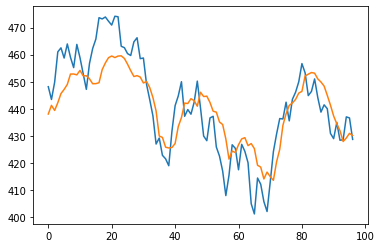

In [ ]:
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())
plt.plot(y_test)
plt.plot(final)

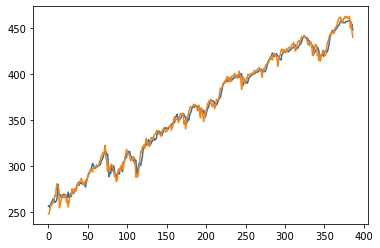

In [ ]:
plt.plot(predict)
plt.plot(original)

### Trading Strategy

In [ ]:
start_amt = 10000

def buy(money, price):
  shares = money / price
  return shares

def sell(shares, price, prev_amt):
  money = shares * price
  if money > prev_amt:
    money = money - 0.25 * (money - prev_amt)
  return money

def trading_strategy(amt, pred, true):
  starting_amt = amt
  holding = False
  for i in range(len(pred)-1):
    if pred[i+1] > pred[i] and not holding:
      shares = buy(amt, true[i])
      prev_amt = amt
      amt = 0
      holding = True
    elif pred[i+1] < pred[i] and holding:
      amt = sell(shares, true[i], prev_amt)
      shares = 0
      holding = False

  buyandhold = buy(starting_amt, true[0])
  buyandhold = sell(buyandhold, true[-1], starting_amt)

  if amt == 0:
    amt = sell(shares, true[-1])

  return amt, buyandhold

In [ ]:
trading_strategy(start_amt, final.flatten(), y_test.flatten())

(9729.728401029084, 9565.873158659064)